## FindIT! UGM 2024     Tim Biasa Aja

### Import Library

In [73]:
# Untuk mengolah data
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score, confusion_matrix

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# Imputer untuk mengatasi nilai null
from sklearn.impute import KNNImputer

# model
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Set rows ke 20 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 20)

import time
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [74]:
X = pd.read_csv("dataset/train_features.csv")
y = pd.read_csv("dataset/train_labels.csv")
test = pd.read_csv("dataset/test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("dataset/submission_format.csv")

### Explore the Dataset

In [75]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values

    return summ

In [76]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [77]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


Dapat dilihat bahwa karakteristik data antara train dan test hampir mirip yakni terdapat sekitar +- 200 data null pada setiap kolom kecuali kolom tanggal menjadi anggota dengan 2700++ data null.

In [78]:
train = pd.concat([X, y], axis=1)
train.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,0
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN,1
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN,4
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN,4


##### Penjelasan Kolom
###### tahun_kelahiran: Tahun kelahiran pelanggan
###### pendidikan: Tingkat pendidikan pelanggan (SMP,SMA,Sarjana,Magister,Doktor)
###### status_pernikahan:	Status pernikahan pelanggan (Sendiri,Rencana Menikah,Menikah,Cerai,Cerai Mati)
###### pendapatan:	Pendapatan pelanggan dalam rupiah
###### jumlah_anak_balita:	Banyaknya anak pelanggan yang masih balita
###### jumlah_anak_remaja:	Banyaknya anak pelanggan yang sudah remaja
###### terakhir_belanja:	Jumlah hari berlalu setelah terakhir belanja
###### belanja_buah:	Biaya yang dikeluarkan untuk belanja buah
###### belanja_daging:	Biaya yang dikeluarkan untuk belanja daging
###### belanja_ikan:	Biaya yang dikeluarkan untuk belanja ikan
###### belanja_kue:	Biaya yang dikeluarkan untuk belanja kue
###### pembelian_diskon:	Banyaknya pembelian yang dilakukan saat diskon
###### pembelian_web:	Banyaknya pembelian yang dilakukan secara daring
###### pembelian_toko:	Banyaknya pembelian yang dilakukan secara luring
###### keluhan:	1 - pernah memberikan keluhan, 0 - tidak pernah
###### tanggal_menjadi_anggota	Pertama kali terdaftar sebagai anggota
###### jumlah_promosi:	(target). Pada promosi ke berapa pelanggan menerima program dari toko, dari total 6 kali promosi yang dilakukan. Nilai 0 berarti tidak menerima sama sekali

### Data Visualization

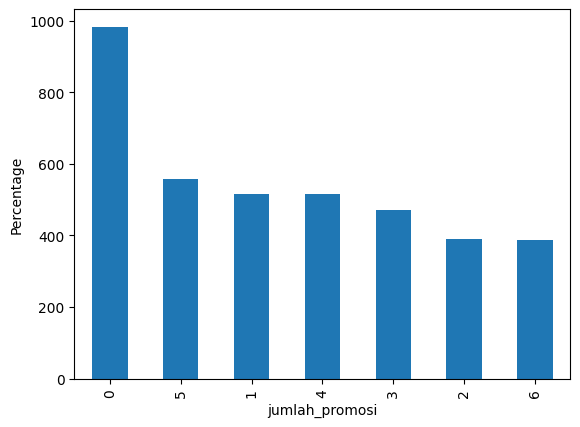

In [79]:
train['jumlah_promosi'].value_counts().plot(kind = 'bar')
plt.ylabel('Percentage')
plt.show()

Dapat dilihat bahwa jumlah data pada setiap kelas tidak merata, terutama pada kelas 0 dengan hampir 1000 data, sedangkan kelas lainnya hanya memiliki data dibawah 600.

<Axes: xlabel='jumlah_promosi'>

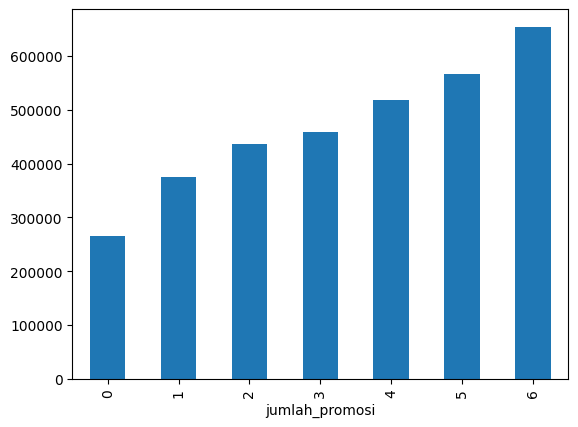

In [80]:
train.groupby('jumlah_promosi')['belanja_daging'].mean().plot(kind='bar')

Dapat dilihat bahwa rata-rata orang belanja daging berbanding lurus dengan jumlah promosi yang diperlukan untuk sampai ke orang tersebut.

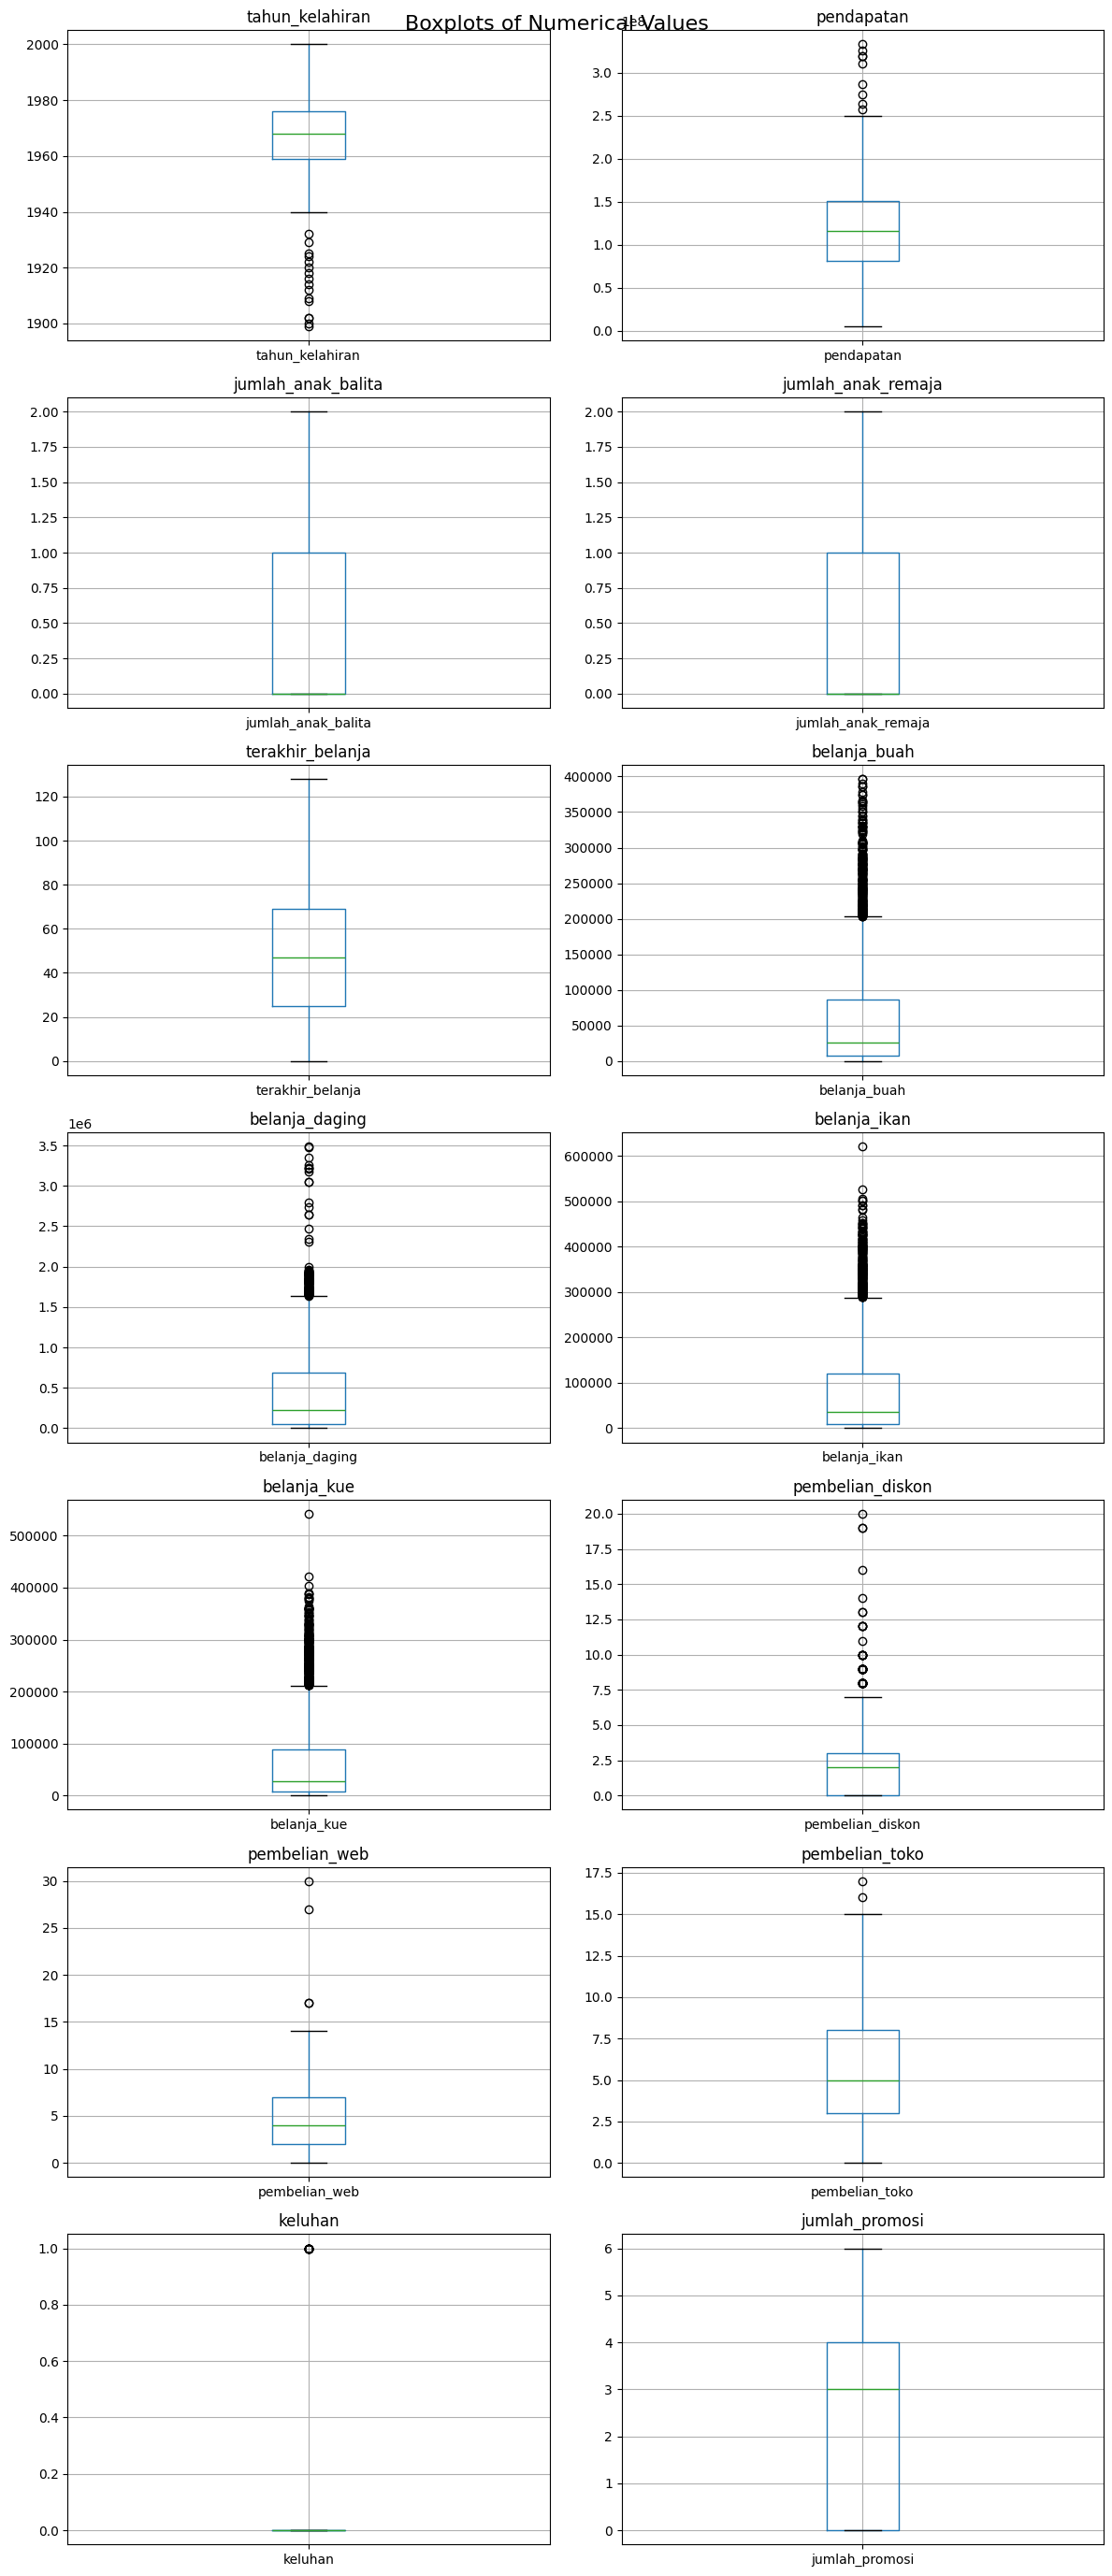

In [81]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

Hampir semua kolom numerik memiliki distribusi yang skew, artinya terdapat data outlier yang dapat dipreprocess sehingga data menjadi lebih bersih.

In [82]:
table = pd.crosstab(train['status_pernikahan'], train['jumlah_promosi'])
table.style.background_gradient()

jumlah_promosi,0,1,2,3,4,5,6
status_pernikahan,,,,,,,
5,1,0,0,0,0,0,0
Cerai,72,34,16,40,11,16,25
Cerai Mati,16,5,3,10,2,1,3
Menikah,338,170,119,124,146,117,100
Rencana Menikah,238,160,167,176,204,197,129
Sendiri,258,120,59,105,120,192,111


Penyebaran status pernikahan pada setiap kelas dapat dikatakan merata, sehingga bisa dikatakan status pernikahan hanya sedikit berpengaruh pada jumlah promosi

In [83]:
table = pd.crosstab(train['pendidikan'], train['jumlah_promosi'])
table.style.background_gradient()

jumlah_promosi,0,1,2,3,4,5,6
pendidikan,,,,,,,
5,2,0,0,0,0,0,0
Doktor,162,54,37,62,10,43,35
Magister,170,91,71,148,126,159,91
SMA,119,63,76,44,55,45,33
SMP,47,10,18,9,0,0,7
Sarjana,424,271,170,195,301,289,191


Hal yang sama juga terjadi pada pendidikan, yang mana setiap kelas dapat dikatakan merata, sehingga bisa dikatakan pendidikan hanya sedikit berpengaruh pada jumlah promosi

### Data Preprocessing

In [84]:
def preprocessing(df):
    # drop kolom yang tidak diperlukan
    df = df.drop(['tanggal_menjadi_anggota','jumlah_anak_remaja','jumlah_anak_balita', 'pendidikan', 'status_pernikahan','keluhan'], axis=1)
    
    # Isi nilai null dengan KNNImputer
    knn = KNNImputer()
    new_df = knn.fit_transform(df)
    df = pd.DataFrame(new_df, columns=df.columns)

    # Tambahkan dengan 50 pada orang yang lahir dibawah 1940, karena sangat jarang usia lebih dari 100
    df['tahun_kelahiran'] = df['tahun_kelahiran'].apply(lambda x: x + 50 if x < 1940 else x)
    # Terdapat beberapa data outlier ekstrim pada pendapatan, sehingga disesuaikan dengan rata-rata pendapatan
    df['pendapatan'] = df['pendapatan'].apply(lambda x: x / 4 if x > 1000000000 else x)
    
    # Ubah tipe data menjadi int64
    numerical_data = df.select_dtypes(include=[np.number]) 
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    return df

Tanggal menjadi anggota sangat banyak nilai null sehingga akan sulit untuk mengisi nilai null tersebut. Jumlah anak remaja dan balita banyak terdapat data tidak masuk akal seperti punya anak namun belum menikah maupun sendiri. Pendidikan dan status pernikahan tersebar rata pada setiap kelas sehingga kecil pengaruhnya. Keluhan hanya didominasi oleh nilai '0' sehingga dapat dihilangkan.

In [85]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,61,1940.000000,2000.000000,1968.033534,11.250294
pendapatan,int64,0,0,3810,5073000.000000,332884000.000000,114059079.492795,43054080.053659
terakhir_belanja,int64,0,0,113,0.000000,128.000000,46.969872,26.611271
belanja_buah,int64,0,0,2700,0.000000,396508.000000,59765.229762,73436.498561
belanja_daging,int64,0,0,3118,0.000000,3489675.000000,439047.466073,506157.060168
belanja_ikan,int64,0,0,2798,0.000000,621600.000000,80537.797223,98473.644490
belanja_kue,int64,0,0,2664,0.000000,542164.000000,63275.771286,78488.840241
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.102698,2.064458
pembelian_web,int64,0,0,18,0.000000,30.000000,4.440398,2.968064
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.714959,3.188680


In [86]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,64,1940.000000,2009.000000,1968.117339,11.253241
pendapatan,int64,0,0,3810,2998899.000000,335080000.000000,115766579.633840,42746464.751216
terakhir_belanja,int64,0,0,116,0.000000,133.000000,47.123101,26.356756
belanja_buah,int64,0,0,2745,0.000000,408646.000000,60818.663960,75684.060810
belanja_daging,int64,0,0,3127,0.000000,3271191.000000,448591.099267,505234.054854
belanja_ikan,int64,0,0,2835,0.000000,574932.000000,84322.832111,102399.967162
belanja_kue,int64,0,0,2699,0.000000,532049.000000,64102.004453,77849.992143
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.107910,2.088903
pembelian_web,int64,0,0,16,0.000000,27.000000,4.491881,2.899064
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.817706,3.237888


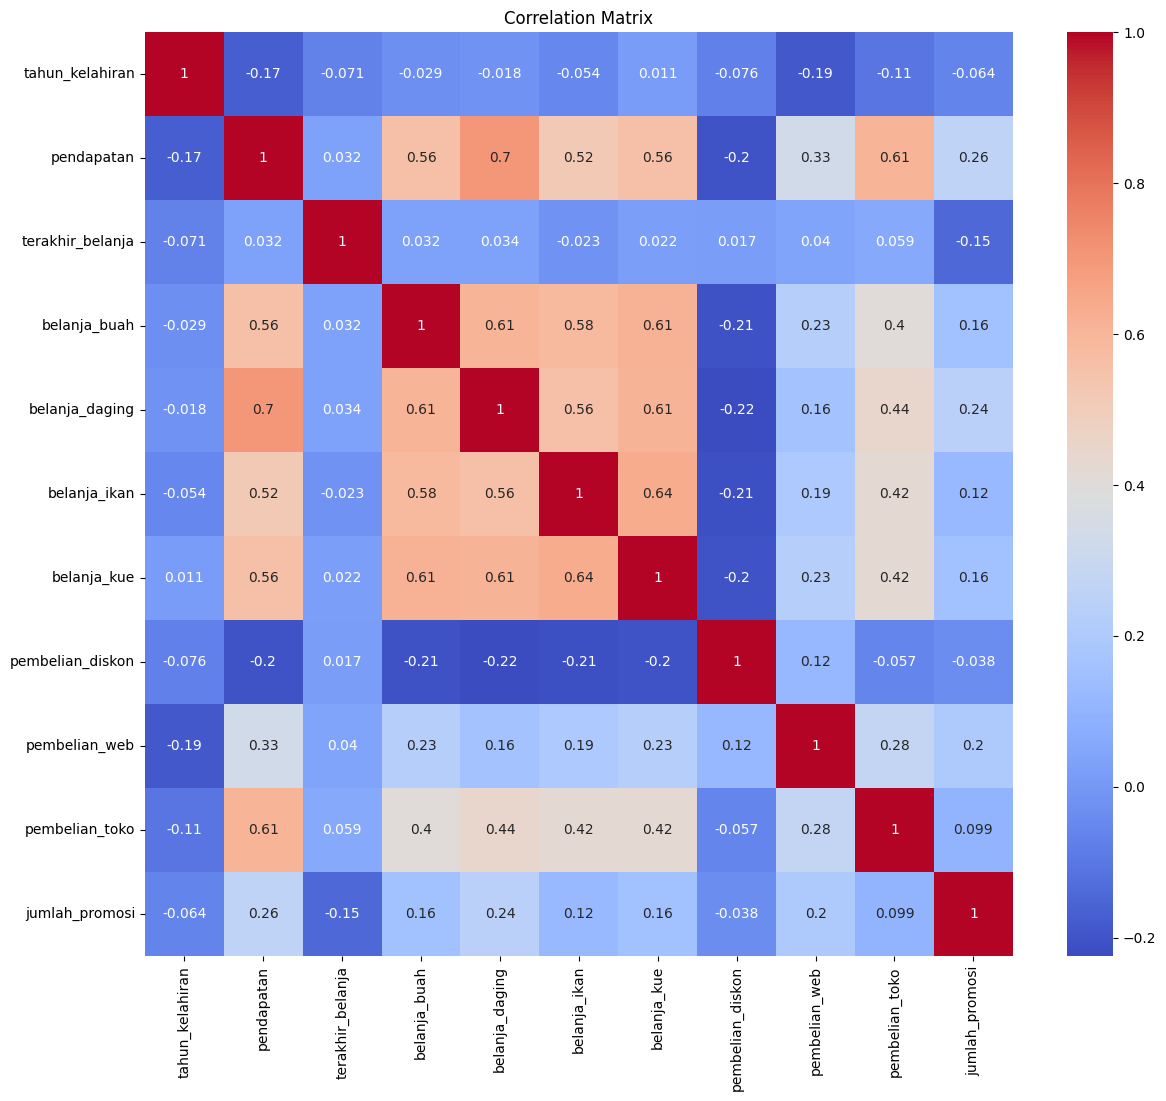

In [87]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

### Final Preparation

In [88]:
# Pisahkan kolom fitur dengan kolom target
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [89]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
y.value_counts()

jumlah_promosi
2    983
0    983
1    983
4    983
5    983
3    983
6    983
Name: count, dtype: int64

Dilakukan SMOTE oversampling agar jumlah data pada setiap kelas menjadi sama (mengikuti jumlah data terbanyak pada kelas tertentu) dan otomatis data yang digunakan dalam proses training juga lebih banyak.

In [90]:
# Shuffle data untuk uji validasi
skf = RepeatedStratifiedKFold(n_splits = 10, random_state = 42)

# Split data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning

In [91]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

#     # Number of features to consider at every split
#     max_features = trial.suggest_int(name="max_features", low=1, high=10)

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=5)
    
    
#     model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="extra_tree", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200,show_progress_bar=True)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

    
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)

In [92]:
# %%time
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
#         'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
#         'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
#     }
        
#     model = LGBMClassifier(**params, random_state =  1, verbose = -1)
    
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)


# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)

In [93]:
# %%time
# def objective(trial):
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.3)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     min_child_weight = trial.suggest_int(name="min_child_weight", low=1, high=32)
#     gamma = trial.suggest_float(name="gamma", low=0.01, high=2.0)
#     colsample_bytree = trial.suggest_float(name="colsample_bytree", low=0.01, high=1.0)
#     reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
#     reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
        
#     model = XGBClassifier(n_estimators = n_estimators, subsample =  subsample, eval_metric = 'mlogloss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, gamma =  gamma, min_child_weight =  min_child_weight, 
#                                         reg_alpha =  reg_alpha, reg_lambda =  reg_lambda, colsample_bytree =  colsample_bytree, random_state =  1)
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, val_idx in skf.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred, average='macro')
#         f1_scores.append(f1)

#     return np.mean(f1_scores)
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200,show_progress_bar=True)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
    
    
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.visualization.plot_optimization_history(study)
# '''
# Number of finished trials:  200
# Best trial:
#   Value:  0.8784390512805642
#   Params: 
#     n_estimators: 881
#     learning_rate: 0.01423451296642755
#     max_depth: 42
#     subsample: 0.5476388113628902
#     min_child_weight: 1
#     gamma: 0.050053803824341866
#     colsample_bytree: 0.6240801156607986
#     reg_alpha: 6.904560693548331e-07
#     reg_lambda: 5.330252227358428e-08
# CPU times: total: 11h 42min 11s
# Wall time: 2h 53min 23s
# '''

In [94]:
# %% time
# def objective(trial):
#     # Define the search space for hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['log_loss']),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_int('max_features', 1, 10),
#         'random_state': 1,
#         'n_jobs': -1
#     }

#     # Initialize the RandomForestClassifier with the suggested hyperparameters
#     rf = RandomForestClassifier(**params)

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the model and make predictions on the test set
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)

#     # Calculate F1 score (macro average) as the metric to optimize
#     f1 = f1_score(y_test, y_pred, average='macro')

#     return f1

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100,show_progress_bar=True)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train a model with the best hyperparameters
# best_rf = RandomForestClassifier(**best_params)
# best_rf.fit(X, y)

#Use the best model for predictions or further analysis

In [95]:
# %%time
# def objective(trial):
#     max_iter = trial.suggest_int(name="max_iter", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.2)
#     l2_regularization = trial.suggest_float(name='l2_regularization', low=0.0, high=10.0)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=2, high=32)
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
        
#     model = HistGradientBoostingClassifier(max_iter = max_iter, l2_regularization =  l2_regularization, loss = 'log_loss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, max_leaf_nodes =  max_leaf_nodes, min_samples_leaf =  min_samples_leaf, 
#                                         max_bins =  255, early_stopping =  False, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="hgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=150)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)

### Cross Validation

In [96]:
# %%time
# # RandomForestClassifier
# RF_cv = cross_val_score(RandomForestClassifier(n_estimators = 736, max_features = 2, max_depth = 77, min_samples_split = 2, 
#                                         min_samples_leaf = 1, criterion = 'log_loss', n_jobs = -1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score of the RF is {RF_cv.mean()} \n")

# # ExtraTreesClassifier
# ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators= 469, max_features= 7, max_depth= 78, min_samples_split= 2, min_samples_leaf= 1,
#                                         criterion = 'log_loss', random_state = 1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

# # HistGradientBoostingClassifier
# HB_cv = cross_val_score(HistGradientBoostingClassifier(max_iter = 666, learning_rate = 0.10444915727802341, l2_regularization = 0.5011733478877418,
#                                         max_depth = 44, max_leaf_nodes = 31, min_samples_leaf = 6, loss = 'log_loss',  max_bins =  255,  
#                                         early_stopping =  False,  random_state =  1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the HB is {HB_cv.mean()} \n")

# # XGBClassifier
# XGB_cv = cross_val_score(XGBClassifier(n_estimators= 881, learning_rate= 0.01423451296642755, max_depth= 42, subsample= 0.5476388113628902,
#                                         min_child_weight= 1, gamma= 0.050053803824341866, colsample_bytree= 0.6240801156607986,
#                                         reg_alpha= 6.904560693548331e-07, reg_lambda= 5.330252227358428e-08, random_state =  1),
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the XGB is {XGB_cv.mean()} \n")

# # LGBMClassifier
# LGBM_cv = cross_val_score(LGBMClassifier(n_estimators= 1900, reg_alpha= 0.004321730352314509, reg_lambda= 0.06129110995893089, 
#                                         colsample_bytree= 0.6, subsample= 0.8, learning_rate= 0.006, max_depth= 100, num_leaves= 157,
#                                         min_child_samples= 8, min_data_per_groups= 56, random_state =  1, verbose = -1), 
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the LGBM is {LGBM_cv.mean()} \n")

In [97]:
'''
The average 10-folds Macro F-Score of the RF is 0.8752411589411574 

The average 10-folds Macro F-Score of the ET is 0.8935404795680525 

The average 10-fold Macro F-Score of the HB is 0.8735233370702076 

The average 10-fold Macro F-Score of the XGB is 0.8763597948951469 

The average 10-fold Macro F-Score of the XGB is 0.8828181829292887 

'''

'\nThe average 10-folds Macro F-Score of the RF is 0.8752411589411574 \n\nThe average 10-folds Macro F-Score of the ET is 0.8935404795680525 \n\nThe average 10-fold Macro F-Score of the HB is 0.8735233370702076 \n\nThe average 10-fold Macro F-Score of the XGB is 0.8763597948951469 \n\nThe average 10-fold Macro F-Score of the XGB is 0.8828181829292887 \n\n'

Berdasarkan hasil tersebut, maka diambil 3 model dengan akurasi tertinggi untuk diexplore lebih lanjut. Model yang dipilih yakni ExtraTreesClassifier, XGBClassifier, LGBMClassifier

### Modelling

In [98]:
etc = ExtraTreesClassifier(
    n_estimators= 469,
    max_features= 7,
    max_depth= 78,
    min_samples_split= 2,
    min_samples_leaf= 1,
    criterion = 'log_loss', 
    random_state = 1)

xgbc = XGBClassifier(
    n_estimators= 881,
    learning_rate= 0.01423451296642755,
    max_depth= 42,
    subsample= 0.5476388113628902,
    min_child_weight= 1,
    gamma= 0.050053803824341866,
    colsample_bytree= 0.6240801156607986,
    reg_alpha= 6.904560693548331e-07,
    reg_lambda= 5.330252227358428e-08,
    random_state =  1)

lgbmc = LGBMClassifier(
    n_estimators= 1900,
    reg_alpha= 0.004321730352314509,
    reg_lambda= 0.06129110995893089,
    colsample_bytree= 0.6,
    subsample= 0.8,
    learning_rate= 0.006,
    max_depth= 100,
    num_leaves= 157,
    min_child_samples= 8,
    min_data_per_groups= 56,
    random_state =  1,
    verbose = -1)

In [99]:
voting = VotingClassifier(estimators=[('et', etc), ('lgbm', lgbmc), ('xgb', xgbc)], voting='hard')
stacking = StackingClassifier(estimators=[('et', etc), ('lgbm', lgbmc), ('vtc', voting)])
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))

F1:  0.8954289187473398


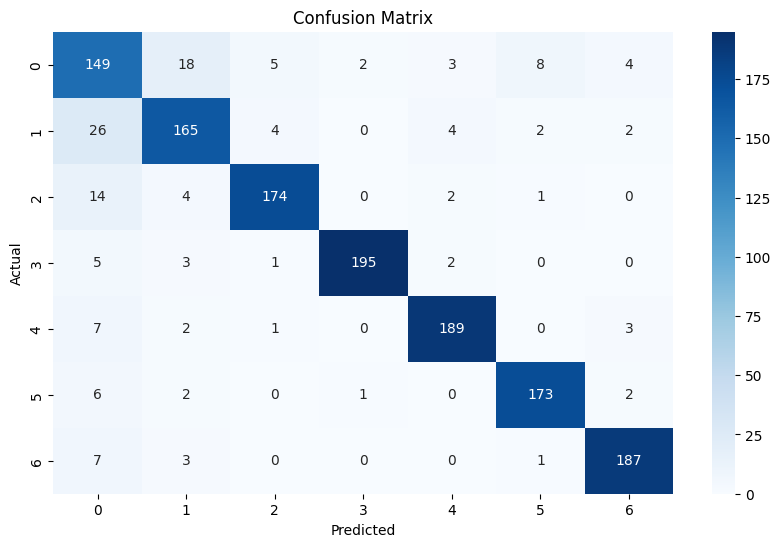

In [100]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Submission

In [101]:
stacking.fit(X, y)

StackingClassifier(estimators=[('et',
                                ExtraTreesClassifier(criterion='log_loss',
                                                     max_depth=78,
                                                     max_features=7,
                                                     n_estimators=469,
                                                     random_state=1)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.6,
                                               learning_rate=0.006,
                                               max_depth=100,
                                               min_child_samples=8,
                                               min_data_per_groups=56,
                                               n_estimators=1900,
                                               num_leaves=157, random_state=1,
                                               reg_alpha=0.004321730352314509,
                                               reg_lambd...
                                                                            grow_policy=None,
                                                                            importance_type=None,
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.01423451296642755,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=42,
                                                                            max_leaves=None,
                                                                            min_child_weight=1,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=881,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=1, ...))]))])

In [102]:
submission = stacking.predict(test)
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format

,ID,jumlah_promosi
0,2241,0
1,2274,5
2,1107,0
3,4478,3
4,5080,4
...,...,...
3813,271,0
3814,3334,1
3815,3478,1
3816,89,1


In [103]:
submission_format.value_counts('jumlah_promosi')

jumlah_promosi
0    1201
5     565
4     514
3     460
1     435
2     322
6     321
Name: count, dtype: int64

In [104]:
submission_format.to_csv('submission_final.csv',index = False)
